1589155200 1677628800 2NpUPCumcMvo4ccIEurUZQlb5dV
<Response [200]>
100 0.0 annual return 0.472 sharpe 0.7 precise_sharpe 0.701 bnh_sharpe 0.808 mdd 0.771 calmar 0.612
100 0.25 annual return 0.407 sharpe 0.632 precise_sharpe 0.634 bnh_sharpe 0.808 mdd 0.584 calmar 0.697
100 0.5 annual return 0.489 sharpe 0.797 precise_sharpe 0.799 bnh_sharpe 0.808 mdd 0.551 calmar 0.887
100 0.75 annual return 0.337 sharpe 0.58 precise_sharpe 0.581 bnh_sharpe 0.808 mdd 0.463 calmar 0.728
100 1.0 annual return 0.175 sharpe 0.323 precise_sharpe 0.324 bnh_sharpe 0.808 mdd 0.669 calmar 0.262
100 1.25 annual return -0.022 sharpe -0.045 precise_sharpe -0.045 bnh_sharpe 0.808 mdd 0.747 calmar -0.029
100 1.5 annual return 0.115 sharpe 0.259 precise_sharpe 0.26 bnh_sharpe 0.808 mdd 0.63 calmar 0.183
100 1.75 annual return 0.219 sharpe 0.553 precise_sharpe 0.554 bnh_sharpe 0.808 mdd 0.772 calmar 0.284
100 2.0 annual return 0.44 sharpe 1.243 precise_sharpe 1.246 bnh_sharpe 0.808 mdd 0.566 calmar 0.777
100 2.25 annu

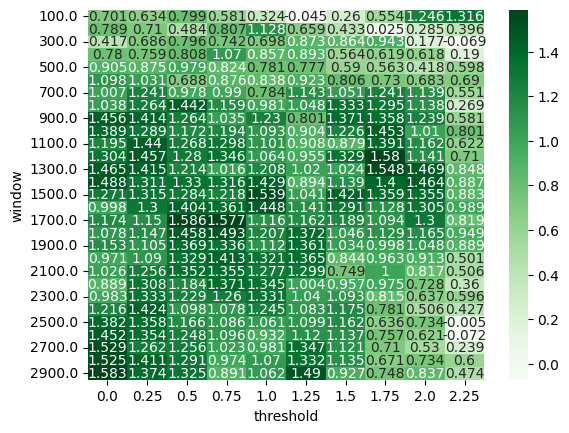

500 1.5 annual return 0.264 sharpe 0.584 precise_sharpe 0.59 bnh_sharpe 0.809 mdd 0.612 calmar 0.431


In [6]:
import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import time

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

##### glassnode api
# insert your API key here
API_KEY = '2NpUPCumcMvo4ccIEurUZQlb5dV'

# set time to download
since = 1589155200 # 2020 May 11
# since = 1646092800 # 2022 Mar 1
until = 1677628800 # 2023 Mar 1
resolution = "1h"

print(since, until, API_KEY)

res = requests.get("https://api.glassnode.com/v1/metrics/market/price_usd_close",
    params={"a": "BTC", "s": since, "u": until, "api_key": API_KEY, "i": resolution})
df_value = pd.read_json(res.text, convert_dates=['t'])

res = requests.get("https://api.glassnode.com/v1/metrics/market/price_usd_close",
    params={"a": "BTC", "s": since, "u": until, "api_key": API_KEY, "i": resolution})
df_price = pd.read_json(res.text, convert_dates=['t'])
print(res)
df = pd.merge(df_value,df_price,how='inner',on='t')
df = df.rename(columns={'v_x':'value','v_y':'price'})

# this part is to import price data
# df = pd.read_csv('BTC-USD.csv')
# df = df[['Date','Close']]
df['chg'] = df['price'].pct_change()

def bband(window, threshold):
    df['ma'] = df['value'].rolling(window).mean()
    df['sd'] = df['value'].rolling(window).std()
    df['z'] = ( df['value'] - df['ma'] ) / df['sd']

    # for i in range(len(df)):
    #     if df.loc[i,'z'] > threshold:
    #         df.loc[i,'pos'] = 1
    #     elif df.loc[i,'z'] < -threshold:
    #         df.loc[i, 'pos'] = -1
    #     else:
    #         df.loc[i, 'pos'] = 0

    df['pos'] = np.where(df['z'] > threshold, 1, np.where(df['z'] < -threshold, -1, 0))

    df['pos_t-1'] = df['pos'].shift(1)
    df['trade'] = abs(df['pos'] - df['pos_t-1'])
    df['pnl'] = df['pos_t-1'] * df['chg'] - df['trade'] * 0.05/100 # 5 bps
    df['cumu'] = df['pnl'].cumsum()
    df['dd'] = df['cumu'].cummax() - df['cumu']

    df['bnh_pnl'] = df['chg']
    df.loc[0:window-1, 'bnh_pnl'] = 0
    df['bnh_cumu'] = df['bnh_pnl'].cumsum()

    annual_return = round(df['pnl'].mean() * 365 * 24, 3)
    sharpe = round(df['pnl'].mean() / df['pnl'].std() * np.sqrt(365 * 24), 3)
    mdd = round(df['dd'].max(), 3)
    calmar = round(annual_return / mdd, 3)

    avg_return = df.loc[window:len(df), 'pnl'].mean()
    return_sd = df.loc[window:len(df), 'pnl'].std()
    precise_sharpe = round(avg_return / return_sd * np.sqrt(365 * 24), 3)

    bnh_sharpe = round(df['bnh_pnl'].mean() / df['bnh_pnl'].std() * np.sqrt(365 * 24), 3)

    # print(df)
    print(window, threshold, 'annual return', annual_return, 'sharpe', sharpe, 'precise_sharpe', precise_sharpe, 'bnh_sharpe', bnh_sharpe, 'mdd', mdd, 'calmar', calmar)

    return pd.Series([window, threshold, precise_sharpe], index=['window', 'threshold', 'sharpe'])

# window_list = [10,20,30,40,50,60,70,80,90,100]
# threshold_list = [0,0.5,1,1.5,2]

window_list = np.arange(100,3000,100)
threshold_list = np.arange(0,2.5,0.25)

##### Optimization 區
### create a list
result_list = []

for window in window_list:
    for threshold in threshold_list:
        result_list.append(bband(window, threshold))

result_df = pd.DataFrame(result_list)
result_df = result_df.sort_values(by='sharpe',ascending=False)
print(result_df)

data_table = result_df.pivot(index='window',columns='threshold',values='sharpe')
sns.heatmap(data_table, annot=True, fmt='g', cmap='Greens')
plt.show()

##### Backtest 區
# parameters
window = 500
threshold = 1.5
bband(window, threshold)
# rsi(window, threshold)
fig = px.line(df, x='t', y=['cumu', 'bnh_cumu', 'dd'], title='strategy')
fig.show()

In [3]:
pip install jupyter

     ---------------------------------------- 0.0/529.7 kB ? eta -:--:--
      --------------------------------------- 10.2/529.7 kB ? eta -:--:--
      --------------------------------------- 10.2/529.7 kB ? eta -:--:--
      --------------------------------------- 10.2/529.7 kB ? eta -:--:--
      --------------------------------------- 10.2/529.7 kB ? eta -:--:--
      --------------------------------------- 10.2/529.7 kB ? eta -:--:--
     -- ---------------------------------- 30.7/529.7 kB 100.9 kB/s eta 0:00:05
     -- ---------------------------------- 41.0/529.7 kB 103.4 kB/s eta 0:00:05
     -- ---------------------------------- 41.0/529.7 kB 103.4 kB/s eta 0:00:05
     ---- -------------------------------- 61.4/529.7 kB 136.5 kB/s eta 0:00:04
     ----- ------------------------------- 71.7/529.7 kB 145.6 kB/s eta 0:00:04
     ----- ------------------------------- 71.7/529.7 kB 145.6 kB/s eta 0:00:04
     ------ ------------------------------ 92.2/529.7 kB 168.9 kB/s eta 0:00: